In [2]:
import copy
import os
import random
import shutil
import zipfile
from math import atan2, cos, sin, sqrt, pi, log
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image,ImageFile
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm
ImageFile.LOAD_TRUNCATED_IMAGES = True

#Print current directory
print(f"Current directory: {os.getcwd()}")
print(f"Files in current directory: {os.listdir('.')}")

# Try to access your data paths
try:
    # Modify this path based on the output of the current directory
    data_path = os.path.join(os.getcwd(),"Data")
    print(f"Data path exists: {os.path.exists(data_path)}")
    if os.path.exists(data_path):
        print(f"Contents of data path: {os.listdir(data_path)}")
except Exception as e:
    print(f"Error: {e}")





Current directory: /home/ubuntu/unet_env
Files in current directory: ['Data', 'NM7.ipynb', 'imageTransform.py', '.venv', 'lib64', 'Unet.ipynb', 'pyvenv.cfg', 'pyproject.toml', 'bin', 'etc', 'lib', 'model_graph.png', 'share', 'uv.lock', '.fr-E8TN82', 'PestNet.ipynb', 'Untitled-1.ipynb', 'model_graph', 'include']
Data path exists: True
Contents of data path: ['Directory 6', 'Directory 8', 'Directory 7', 'Directory 4', 'Directory 1', 'Directory 5', 'Natural', 'Directory 3', 'Directory 2', 'Mask']


In [6]:
def find_folders(base_path, target_folder):
    """Search for a target folder in the directory structure"""
    print(f"Searching for '{target_folder}' from base path: {base_path}")
    results = []
    
    for root, dirs, files in os.walk(base_path):
        if target_folder in dirs:
            found_path = os.path.join(root, target_folder)
            results.append(found_path)
            print(f"Found: {found_path}")
    
    return results
############################################################################################

In [3]:
class PlantDataset(Dataset):
    def __init__(self, image_path, mask_path, limit=None):
        self.image_path = image_path
        self.mask_path = mask_path
        self.limit = limit
        # Get image and mask files directly from the provided paths
        self.images = sorted([os.path.join(image_path, i) for i in os.listdir(image_path)])
        self.masks = sorted([os.path.join(mask_path, i) for i in os.listdir(mask_path)])
        if self.limit is not None:
            self.images = self.images[:self.limit]
            self.masks = self.masks[:self.limit]
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor()
        ])
    
    def __getitem__(self, index):
        try:
            img = Image.open(self.images[index]).convert("RGB")
            mask = Image.open(self.masks[index]).convert("L")
            img_tensor = self.transform(img)
            mask_tensor = self.transform(mask)
            mask_tensor = (mask_tensor != 0).float() # Ensure binary mask



            # Extract filename (e.g., "image123.png")
            img_filename = os.path.basename(self.images[index])
            return img_tensor, mask_tensor,img_filename
        except Exception as e:
            # Return a placeholder or the next valid image
            return self.__getitem__((index + 1) % len(self))
    
    def __len__(self):
        return len(self.images)

    

Current working directory: /home/ubuntu/unet_env
Searching for 'Data' from base path: /home/ubuntu/unet_env
Found: /home/ubuntu/unet_env/Data
Using image path: /home/ubuntu/unet_env/Data/Directory 1
Using mask path: /home/ubuntu/unet_env/Data/Directory 2


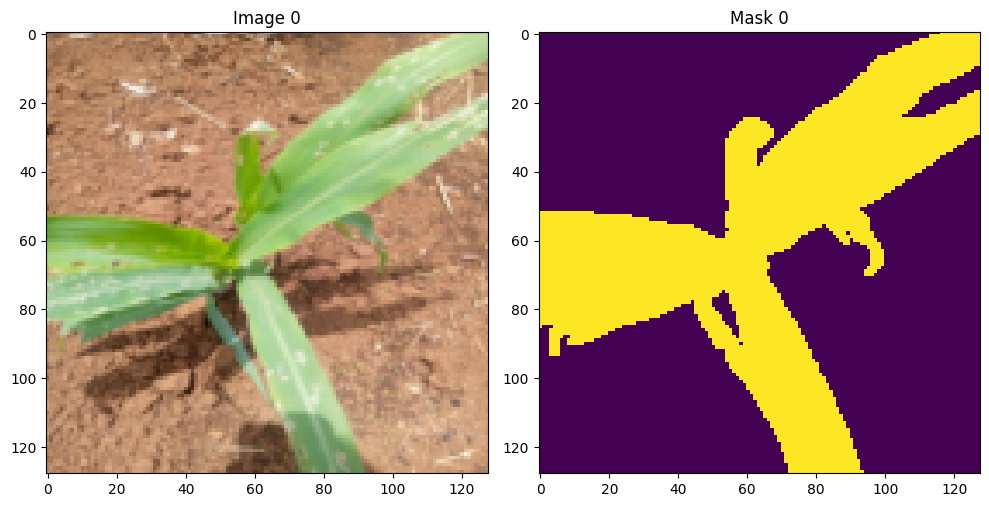

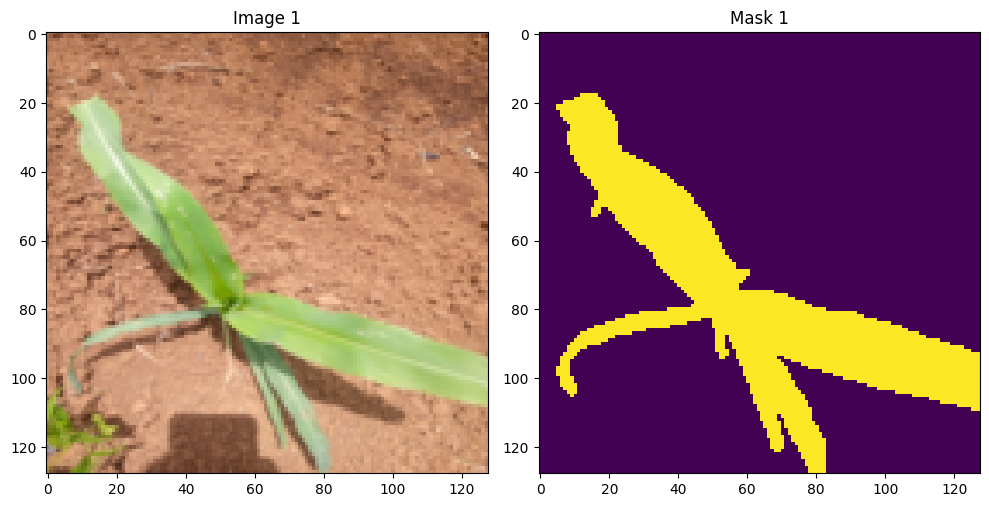

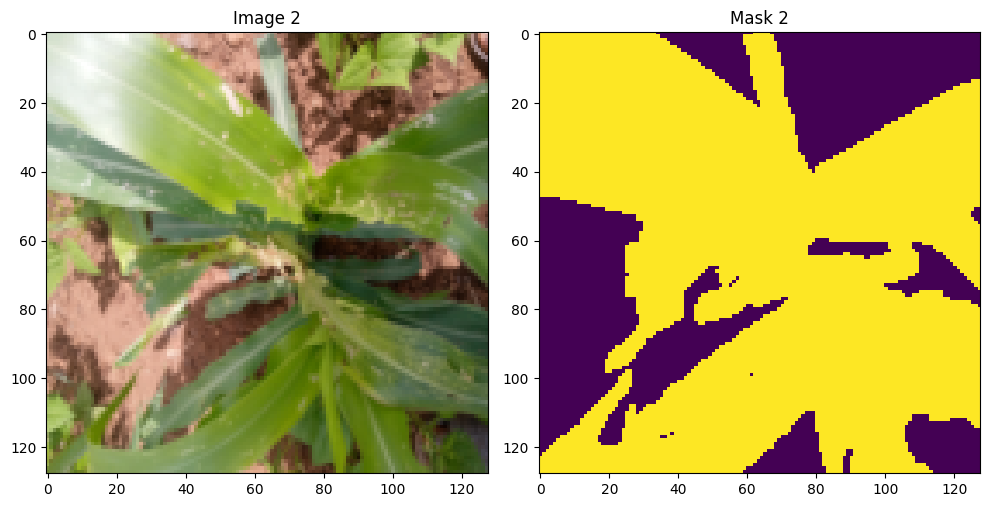

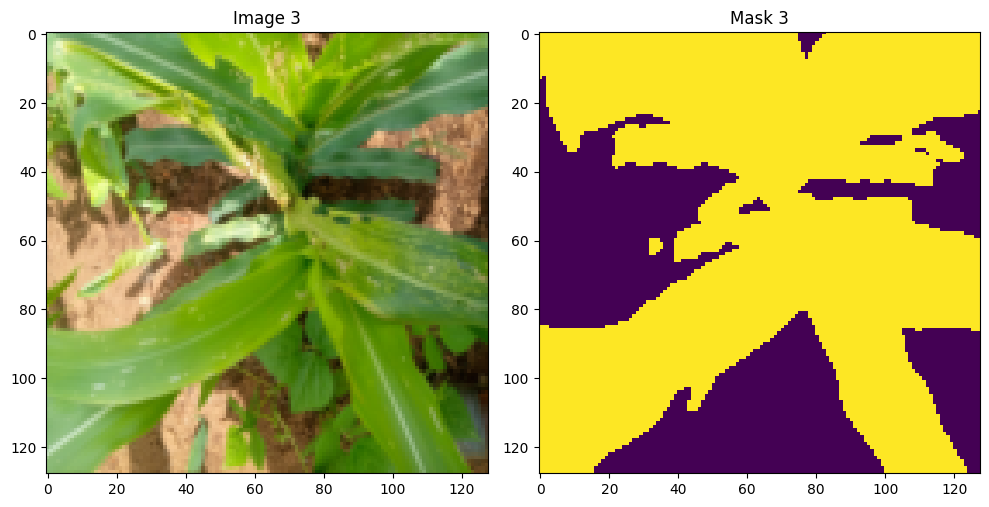

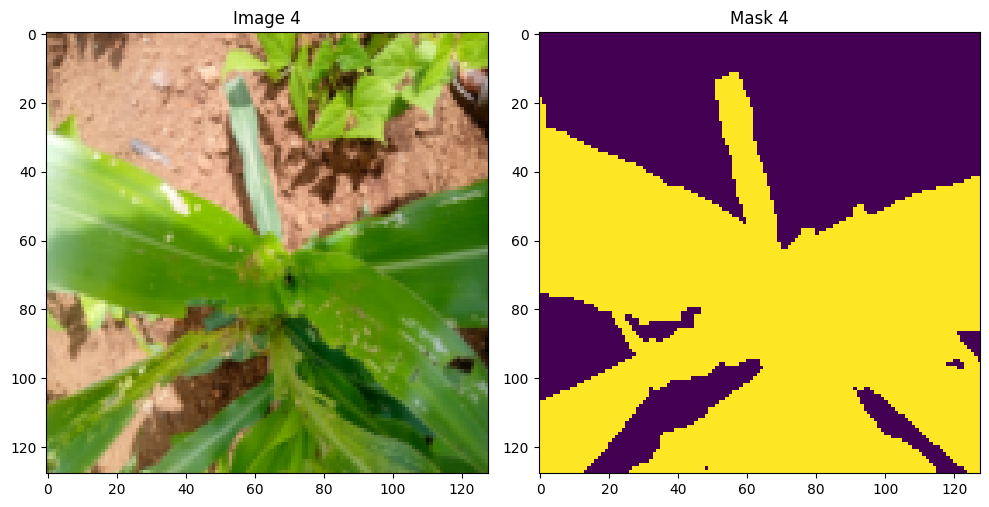

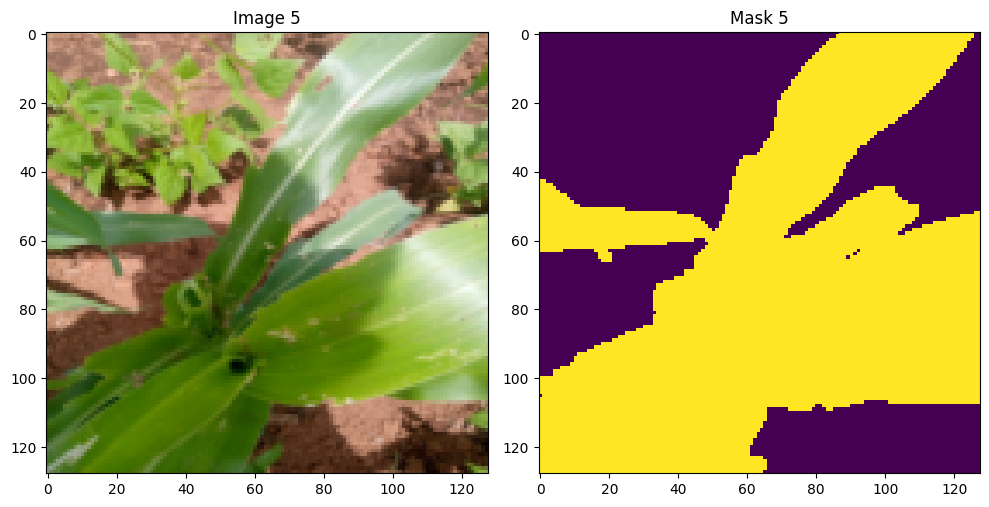

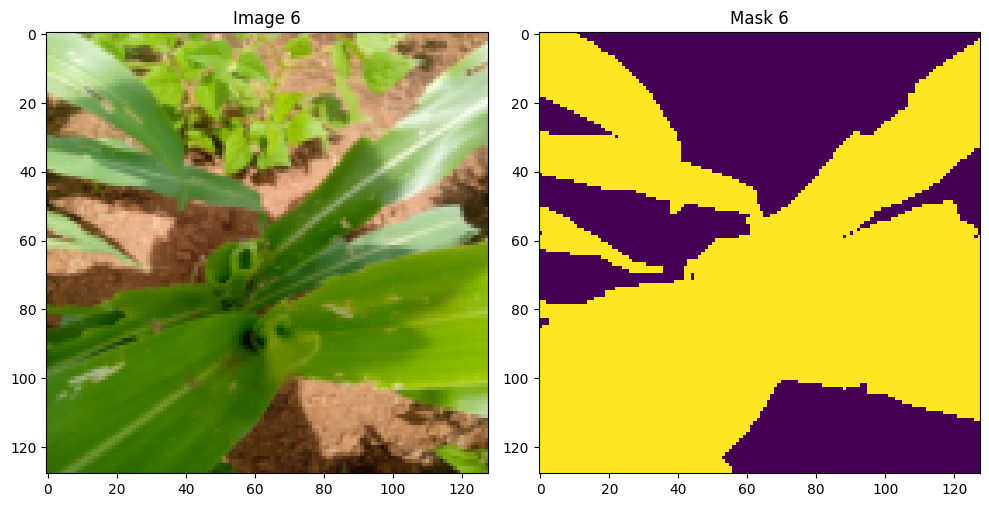

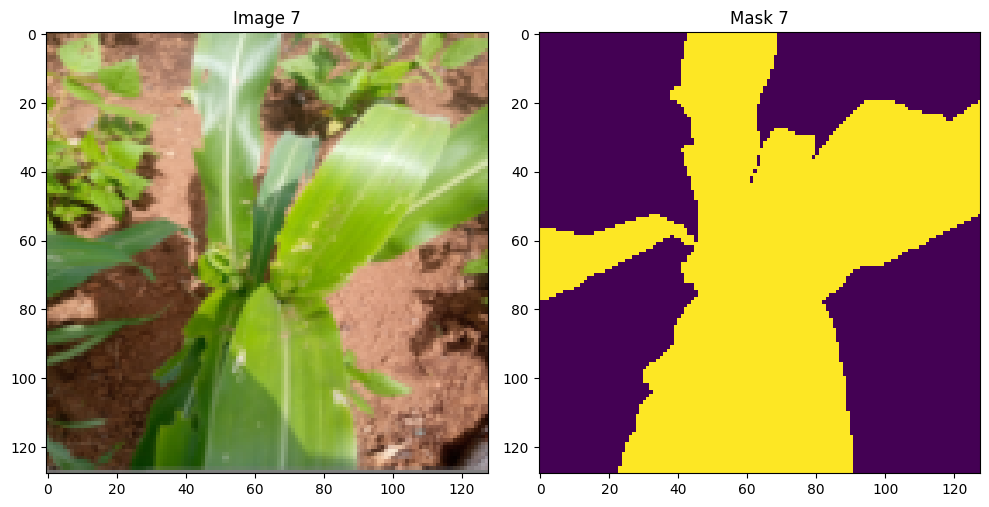

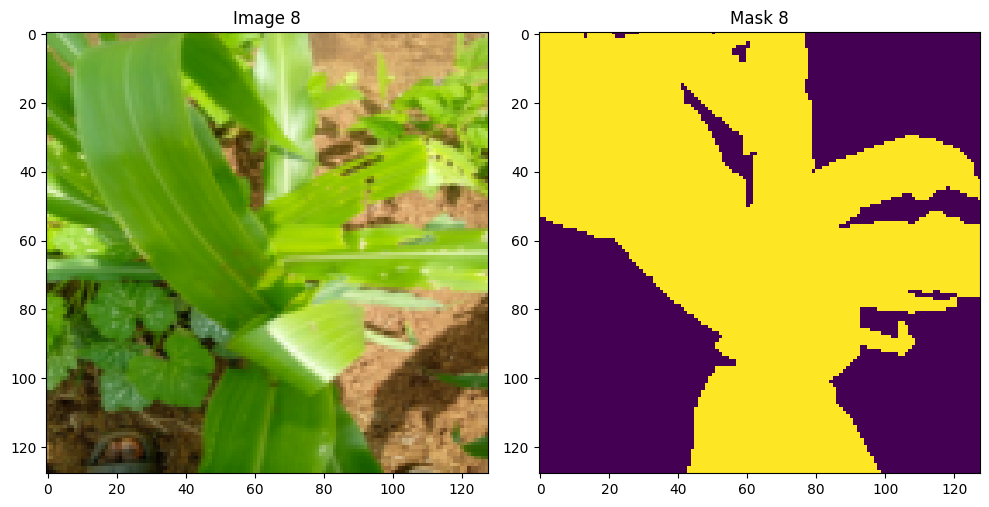

In [13]:
# Get the current working directory
base_path = os.getcwd()
print(f"Current working directory: {base_path}")

# Search for the plant_data folders
data_paths = find_folders(base_path, "Data")

if not data_paths:
    # Try looking for specific folders
    natural_paths = find_folders(base_path, "Directory 1")
    mask_paths = find_folders(base_path, "Directory 2")
    
    if natural_paths and mask_paths:
        natural_path = natural_paths[0]
        mask_path = mask_paths[0]
    else:
        print("Could not find data folders automatically.")
        # Hard code the paths based on your screenshot
        natural_path = os.path.join(base_path, "UNET_ENV", "Data", "Directory 1")
        mask_path = os.path.join(base_path, "UNET_ENV", "Data", "Directory 2")
else:
    # Construct paths based on found plant_data folder
    plant_data_path = data_paths[0]
    natural_path = os.path.join(plant_data_path, "Directory 1")
    mask_path = os.path.join(plant_data_path, "Directory 2")

print(f"Using image path: {natural_path}")
print(f"Using mask path: {mask_path}")

# Check if directories exist
if not os.path.exists(natural_path): 
    raise FileNotFoundError(f"Error: Image directory not found at {natural_path}")


if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Error: Mask directory not found at {mask_path}")

    
# Create dataset and dataloader
dataset = PlantDataset(
    image_path=natural_path,
    mask_path=mask_path,
    limit=1308#t to an integer if you want to limit the dataset size
)
#fig, ax = plt.subplots(1, 2, figsize=(10, 5))

try:
    for i in range(1308):
        # Create a new figure for each iteration
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
       
        # Get data
        img, mask, _ = dataset[i]
        image = img.permute(1, 2, 0).cpu().numpy()
        mask = mask.permute(1, 2, 0).cpu().numpy()
       
        # Display images
        ax[0].imshow(image)
        ax[0].set_title(f"Image {i}")
        ax[1].imshow(mask)
        ax[1].set_title(f"Mask {i}")
       
        plt.tight_layout()
        plt.show()
       
        # Ask for input to continue
        try:
            user_input = input("Press Enter to continue or 'q' to quit: ")
            if user_input.lower() == 'q':
                plt.close(fig)  # Close before breaking
                break
        except KeyboardInterrupt:
            print("\nInterrupted by user. Closing...")
            plt.close(fig)  # Close before breaking
            break
       
        # Close the figure to free memory after user interaction
        plt.close(fig)
           
except KeyboardInterrupt:
    print("\nInterrupted by user. Closing...")

In [18]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder - only 2 layers
        self.enc1 = self._block(3, 32)
        self.enc2 = self._block(32,64)
        

        # Bottleneck
        self.bottleneck = self._block(64, 128)
        
        # Decoder - only 2 layers
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._block (128,64)
        self.up2 = nn.ConvTranspose2d(64,32, kernel_size=2, stride=2)
        self.dec2 = self._block(64,32)
        
        # Output
        self.out = nn.Conv2d(32, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2)
        
    def _block(self, in_channels, out_channels, dilation=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                    padding=dilation, dilation=dilation),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                    padding=dilation, dilation=dilation),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # Encoder - only 2 layers
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.pool(enc2))
        
        # Decoder - only 2 layers
        dec1 = self.up1(bottleneck)
        dec1 = torch.cat((dec1, enc2), dim=1)
        dec1 = self.dec1(dec1)
        
        dec2 = self.up2(dec1)
        dec2 = torch.cat((dec2, enc1), dim=1)
        dec2 = self.dec2(dec2)
        
        # Output
        out = self.out(dec2)
        return self.sigmoid(out)
#########################################################################################################

In [22]:
def train_model(model, train_loader, device, num_epochs=10):
    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_history = []
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        # Create progress bar for batches
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', 
                   unit='batch', leave=True)
        
        for images, masks , _ in pbar:
            # Move tensors to the configured device
            images = images.to(device)
            masks = masks.to(device)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
            # Update progress bar with current loss
            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / len(train_loader)
        loss_history.append(avg_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs} completed, Average Loss: {avg_loss:.4f}')
    
    return model, loss_history

In [ ]:
from sympy import intersection


def visualize_predictions(model, dataset, device, num_samples=3,loss_history=None, show_overlay=True,show_iou=True):
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    # Determine number of columns based on whether overlay is shown
    num_cols = 3  # Base: image, ground truth, predicted
    if show_overlay:
        num_cols += 1
    if show_iou:
        num_cols += 1
    
    plt.figure(figsize=(15, num_samples * 4))
    
    for i, idx in enumerate(indices):
        image, true_mask, filename = dataset[idx]

        image_input = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_mask = model(image_input)
            
        
        pred_mask = pred_mask.squeeze().cpu().numpy()
       # print(pred_mask)
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)  # binarize
        image_np = image.permute(1, 2, 0).cpu().numpy()
        true_mask_np = true_mask.squeeze().cpu().numpy()
        appl_mask = image_np * pred_mask_bin[..., np.newaxis]

        
        # Calculate intersection and union
        intersection = np.logical_and(pred_mask_bin, true_mask_np)  #A∩B is the number of pixels where both prediction and truth are 1 (intersection)
        union = np.logical_or(pred_mask_bin, true_mask_np) #A∪B is the number of pixels where either is 1 (union)
        iou = np.sum(intersection) / (np.sum(union) + 1e-8)  # avoid division by zero
        # Dice coefficient
        dice = (2.0 * np.sum(intersection)) / (np.sum(pred_mask_bin) + np.sum(true_mask_np) + 1e-8)

        print(f"IOU for sample {i}: {iou:.4f}\nDice: {dice:.4f}")


        # Calculate Dice
        # Plot original image
        plt.subplot(num_samples, num_cols, i * num_cols + 1)
        plt.imshow(image_np)
        plt.title("Image")
        plt.axis("off")
        
        # Plot ground truth mask
        plt.subplot(num_samples, num_cols, i * num_cols + 2)
        plt.imshow(true_mask_np, cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")
        
        # Plot predicted mask
        plt.subplot(num_samples, num_cols, i * num_cols + 3)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title(f"Predicted Mask\n{filename}")
        plt.axis("off")

     # Plot overlay if requested
        if show_overlay:
            plt.subplot(num_samples, num_cols, i * num_cols + 4)
            
            # Create RGB overlay
            overlay = np.zeros((image_np.shape[0], image_np.shape[1], 3))
            
            # Green channel for true mask
            overlay[:, :, 1] = true_mask_np * 0.7
            
            # Red channel for predicted mask
            overlay[:, :, 0] = pred_mask * 0.7
            
            # Yellow indicates overlap between true and predicted
            plt.imshow(overlay)
            plt.title("Overlay (Green=True, Red=Pred)")
            plt.axis("off")
        if show_iou:
            col_offset = 5 if show_overlay else 4
            plt.subplot(num_samples, num_cols, i * num_cols + col_offset)
            inter_union_img = np.zeros_like(image_np)
            inter_union_img[:, :, :] = 0  # background
            inter_union_img[union] = [0, 0, 1]  # blue for union
            inter_union_img[intersection] = [1, 1, 1]  # white for intersection
            plt.imshow(inter_union_img)
            plt.title(f"IoU: {iou:.3f}\n Dice :{dice:.3f}")
            plt.axis("off")
       
    plt.tight_layout()
    plt.show()
    if loss_history is not None and len(loss_history) > 0:
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(loss_history) + 1), loss_history, marker='o')
        plt.title('Training Loss vs. Epochs')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()
    plt.figure(figsize=(20, 16))
    plt.suptitle("Applied Masks for First 20 Samples", fontsize=16)
    
    # Get first 20 indices (or fewer if dataset is smaller)
    grid_indices = list(range(min(20, len(dataset))))
    
    # Create 4x5 grid for 20 samples
    rows, cols = 4, 5
    
    for i, idx in enumerate(grid_indices):
        image, true_mask , filename = dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        
        with torch.no_grad():
            pred_mask = model(image_input)
            
        pred_mask = pred_mask.squeeze().cpu().numpy()
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
        image_np = image.permute(1, 2, 0).cpu().numpy()
        appl_mask = image_np * pred_mask_bin[..., np.newaxis]
        
        # Calculate IoU for title
        true_mask_np = true_mask.squeeze().cpu().numpy()
        intersection = np.logical_and(pred_mask_bin, true_mask_np)
        union = np.logical_or(pred_mask_bin, true_mask_np)
        iou = np.sum(intersection) / (np.sum(union) + 1e-8)
        
        plt.subplot(rows, cols, i + 1)
        plt.imshow(appl_mask)
        plt.title(f"Sample {idx}\n{filename}\nIoU: {iou:.3f}", fontsize=10)
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

#################################################################################################


In [ ]:
def save_predictions(model, dataset, save_path, device):
    model.eval()
    os.makedirs(save_path, exist_ok=True)

    for idx in range(len(dataset)):
        image, _= dataset[idx]
        image_input = image.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_mask = model(image_input).squeeze().cpu().numpy()

        pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255
        save_name = os.path.join(save_path, f"mask_{idx}.png")
        cv2.imwrite(save_name, pred_mask)
###################################################################################################

In [20]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Get the current working directory
base_path = os.getcwd()
print(f"Current working directory: {base_path}")

# Search for the plant_data folders
data_paths = find_folders(base_path, "Data")

if not data_paths:
    # Try looking for specific folders
    natural_paths = find_folders(base_path, "Directory 1")
    mask_paths = find_folders(base_path, "Directory 2")
    
    if natural_paths and mask_paths:
        natural_path = natural_paths[0]
        mask_path = mask_paths[0]
    else:
        print("Could not find data folders automatically.")
        # Hard code the paths based on your screenshot
        natural_path = os.path.join(base_path, "UNET_ENV", "Data", "Directory 1")
        mask_path = os.path.join(base_path, "UNET_ENV", "Data", "Directory 2")
else:
    # Construct paths based on found plant_data folder
    plant_data_path = data_paths[0]
    natural_path = os.path.join(plant_data_path, "Directory 1")
    mask_path = os.path.join(plant_data_path, "Directory 2")

print(f"Using image path: {natural_path}")
print(f"Using mask path: {mask_path}")

# Check if directories exist
if not os.path.exists(natural_path): 
    raise FileNotFoundError(f"Error: Image directory not found at {natural_path}")


if not os.path.exists(mask_path):
    raise FileNotFoundError(f"Error: Mask directory not found at {mask_path}")

    
# Create dataset and dataloader
dataset = PlantDataset(
    image_path=natural_path,
    mask_path=mask_path,
    limit=10#t to an integer if you want to limit the dataset size
)

Using device: cpu
Current working directory: /home/ubuntu/unet_env
Searching for 'Data' from base path: /home/ubuntu/unet_env
Found: /home/ubuntu/unet_env/Data
Using image path: /home/ubuntu/unet_env/Data/Directory 1
Using mask path: /home/ubuntu/unet_env/Data/Directory 2


In [23]:
# Create data loader
generator = torch.Generator().manual_seed(25)
train_loader = DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=True, 
    generator=generator,
    num_workers=2
)

# Create and train the model
model = UNet().to(device)
trained_model, loss_history = train_model(model, train_loader, device, num_epochs=5)
print("Training time:",time.time())

Epoch 1/5: 100%|██████████| 5/5 [00:21<00:00,  4.21s/batch, Loss=0.6906]


Epoch 1/5 completed, Average Loss: 0.6935


Epoch 2/5: 100%|██████████| 5/5 [00:25<00:00,  5.09s/batch, Loss=0.6976]


Epoch 2/5 completed, Average Loss: 0.6913


Epoch 3/5: 100%|██████████| 5/5 [00:22<00:00,  4.42s/batch, Loss=0.6798]


Epoch 3/5 completed, Average Loss: 0.6851


Epoch 4/5: 100%|██████████| 5/5 [00:24<00:00,  4.98s/batch, Loss=0.6540]


Epoch 4/5 completed, Average Loss: 0.6679


Epoch 5/5: 100%|██████████| 5/5 [00:22<00:00,  4.47s/batch, Loss=0.5866]

Epoch 5/5 completed, Average Loss: 0.6235
Training time: 1752843442.8731363


In [24]:
# Save the model
#save_predictions(trained_model, dataset, "predicted_masks", device)
visualize_predictions(
    trained_model, 
    dataset, 
    device, 
    num_samples=10,
    loss_history=loss_history,  # Pass the loss history for plotting
    show_overlay=True  # Enable the overlay visualization
)

print("Training complete! Model saved.")


indices=[0, 7, 9, 2, 8, 3, 6, 1, 4, 5]
Training complete! Model saved.


In [ ]:
from torchviz import make_dot
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)

# Create a sample input and move it to the same device as the model
x = torch.randn(1, 3, 224, 224).to(device)  # <-- Add .to(device) here

y = model(x)

# Create visualization
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("model_graph", format="png")

'model_graph.png'